In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

# 讀取 CSV 檔案
file_path = "C:/Users/USER/Downloads/NLP-Courses/NLP220/Assignments/processed_books_data.csv"
df = pd.read_csv(file_path)

# 篩選只包含 1, 2, 4, 5 星評分的資料
df_filtered = df[df['review/score'].isin([1, 2, 4, 5])]

# 新增 'label' 欄位，根據評分來分類：4或5星為正面(1)，1或2星為負面(0)
df_filtered['label'] = df_filtered['review/score'].apply(lambda x: 1 if x >= 4 else 0)

# 移除 'review/text' 欄位中為 NaN 的列
df_filtered = df_filtered.dropna(subset=['review/text'])

# 分割資料集，85% 用於訓練，15% 用於測試
train_data, test_data = train_test_split(df_filtered, test_size=0.15, random_state=42, stratify=df_filtered['label'])

# 使用 CountVectorizer 進行文本轉換
vectorizer_count = CountVectorizer(stop_words='english', max_features=1000)
X_train_count = vectorizer_count.fit_transform(train_data['review/text'])
X_test_count = vectorizer_count.transform(test_data['review/text'])

# 自定義的 Naive Bayes 分類器
class MyNaiveBayes:
    def __init__(self, alpha=1):
        self.alpha = alpha
        self.class_priors = None
        self.feature_log_prob = None
        self.classes = None
    
    def fit(self, X, y):
        # 取得唯一的類別標籤
        self.classes = np.unique(y)
        # 計算每個類別的先驗機率 P(y)
        self.class_priors = np.zeros(len(self.classes))
        for idx, c in enumerate(self.classes):
            self.class_priors[idx] = np.sum(y == c) / len(y)
        
        # 計算條件機率 P(x|y) 並使用拉普拉斯平滑
        feature_count = np.zeros((len(self.classes), X.shape[1]))
        for idx, c in enumerate(self.classes):
            feature_count[idx, :] = np.sum(X[y == c], axis=0)
        
        # 使用 alpha 進行平滑
        self.feature_log_prob = np.log((feature_count + self.alpha) / 
                                       (feature_count.sum(axis=1, keepdims=True) + self.alpha * X.shape[1]))
    
    def predict(self, X):
        log_probs = np.log(self.class_priors) + X @ self.feature_log_prob.T
        return self.classes[np.argmax(log_probs, axis=1)]


# 使用 sklearn 的 MultinomialNB 模型
sklearn_nb = MultinomialNB()
sklearn_nb.fit(X_train_count, train_data['label'])
sklearn_preds = sklearn_nb.predict(X_test_count)

# 使用自定義 Naive Bayes 模型
my_nb = MyNaiveBayes()
my_nb.fit(X_train_count.toarray(), train_data['label'].values)
my_preds = my_nb.predict(X_test_count.toarray())

# 計算並顯示結果
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    print(f"{model_name} Accuracy: {accuracy}")
    print(f"{model_name} F1 Score: {f1}")
    print(f"{model_name} Confusion Matrix:\n{cm}\n")

# 評估 sklearn 和自定義模型的表現
evaluate_model(test_data['label'], sklearn_preds, "Sklearn Naive Bayes")
evaluate_model(test_data['label'], my_preds, "My Naive Bayes")


Sklearn Naive Bayes Accuracy: 0.8747180439717862
Sklearn Naive Bayes F1 Score: 0.7320381100061164
Sklearn Naive Bayes Confusion Matrix:
[[ 29863  23049]
 [ 28549 330394]]

My Naive Bayes Accuracy: 0.8747180439717862
My Naive Bayes F1 Score: 0.7320381100061164
My Naive Bayes Confusion Matrix:
[[ 29863  23049]
 [ 28549 330394]]



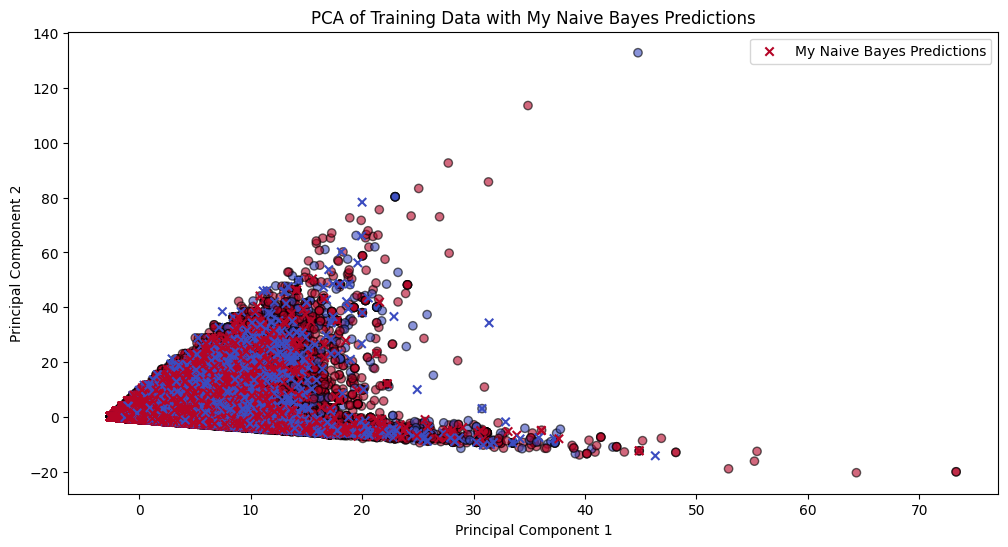

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 使用 PCA 將詞頻矩陣降維到 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_count.toarray())
X_test_pca = pca.transform(X_test_count.toarray())

# 可視化 sklearn Naive Bayes 的分類結果
plt.figure(figsize=(12, 6))

# 繪製訓練數據的散佈圖
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_data['label'], cmap='coolwarm', edgecolor='k', alpha=0.6)

# 使用自定義 Naive Bayes 模型的預測
my_preds_pca = my_nb.predict(X_test_count.toarray())
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=my_preds_pca, cmap='coolwarm', marker='x', label='My Naive Bayes Predictions')

plt.title('PCA of Training Data with My Naive Bayes Predictions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

# 讀取 CSV 檔案
file_path = "Books_rating.csv"
df = pd.read_csv(file_path)

# 篩選只包含 1, 2, 4, 5 星評分的資料
df_filtered = df[df['review/score'].isin([1, 2, 4, 5])]

# 新增 'label' 欄位，根據評分來分類：4或5星為正面(1)，1或2星為負面(0)
df_filtered['label'] = df_filtered['review/score'].apply(lambda x: 1 if x >= 4 else 0)

# 移除 'review/text' 欄位中為 NaN 的列
df_filtered = df_filtered.dropna(subset=['review/text'])

# 分割資料集，85% 用於訓練，15% 用於測試
train_data, test_data = train_test_split(df_filtered, test_size=0.15, random_state=42, stratify=df_filtered['label'])

class MyNaiveBayes:
    def __init__(self, alpha=10):
        self.alpha = alpha
        self.class_priors = None
        self.feature_log_prob = None
        self.classes = None
    
    def fit(self, X, y):
        # 取得唯一的類別標籤
        self.classes = np.unique(y)
        # 計算每個類別的先驗機率 P(y)
        self.class_priors = np.zeros(len(self.classes))
        for idx, c in enumerate(self.classes):
            self.class_priors[idx] = np.sum(y == c) / len(y)
        
        # 使用 scipy 稀疏矩陣操作
        feature_count = np.zeros((len(self.classes), X.shape[1]))
        for idx, c in enumerate(self.classes):
            # 直接在稀疏矩陣 X 上進行操作
            feature_count[idx, :] = X[y == c].sum(axis=0)

        # 使用 alpha 進行平滑
        self.feature_log_prob = np.log((feature_count + self.alpha) / 
                                       (feature_count.sum(axis=1, keepdims=True) + self.alpha * X.shape[1]))
    
    def predict(self, X):
        log_probs = np.log(self.class_priors) + X @ self.feature_log_prob.T
        return self.classes[np.argmax(log_probs, axis=1)]

# 計算並顯示結果
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    print(f"{model_name} Accuracy: {accuracy}")
    print(f"{model_name} F1 Score: {f1}")
    print(f"{model_name} Confusion Matrix:\n{cm}\n")



C:\Users\USER\AppData\Local\Temp\ipykernel_47452\1814875144.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'] = df_filtered['review/score'].apply(lambda x: 1 if x >= 4 else 0)


In [9]:
# 1. CountVectorizer
print("Calculate the 1st feature: CountVectorizer")
vectorizer_count = CountVectorizer(stop_words='english', max_features=3000)
X_train_count = vectorizer_count.fit_transform(train_data['review/text'])
X_test_count = vectorizer_count.transform(test_data['review/text'])

# My Naive Bayes
print("My Naive Bayes ANS")
my_nb = MyNaiveBayes()
my_nb.fit(X_train_count, train_data['label'].values)  # 不使用 toarray()
my_preds = my_nb.predict(X_test_count)  # 不使用 toarray()
evaluate_model(test_data['label'], my_preds, "My Naive Bayes - CountVectorizer")

# Sklearn Naive Bayes
print("Sklearn ANS")
sklearn_nb = MultinomialNB()
sklearn_nb.fit(X_train_count, train_data['label'])
sklearn_preds = sklearn_nb.predict(X_test_count)
evaluate_model(test_data['label'], sklearn_preds, "Sklearn Naive Bayes - CountVectorizer")

# 2. TF-IDF
print("Calculate the 2nd feature: TF-IDF")
vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_tfidf = vectorizer_tfidf.fit_transform(train_data['review/text'])
X_test_tfidf = vectorizer_tfidf.transform(test_data['review/text'])

# My Naive Bayes
print("My Naive Bayes ANS")
my_nb.fit(X_train_tfidf, train_data['label'].values)  # 不使用 toarray()
my_preds = my_nb.predict(X_test_tfidf)  # 不使用 toarray()
evaluate_model(test_data['label'], my_preds, "My Naive Bayes - TF-IDF")

# Sklearn Naive Bayes
print("Sklearn ANS")
sklearn_nb.fit(X_train_tfidf, train_data['label'])
sklearn_preds = sklearn_nb.predict(X_test_tfidf)
evaluate_model(test_data['label'], sklearn_preds, "Sklearn Naive Bayes - TF-IDF")

# 3. Combined [review/summary] & [review/text] using TfidfVectorizer
print("Calculate the 3rd feature: Combine [review/summary] & [review/text] using TfidfVectorizer")
train_data['combined_text'] = train_data['review/summary'].fillna('') + " " + train_data['review/text']
test_data['combined_text'] = test_data['review/summary'].fillna('') + " " + test_data['review/text']

vectorizer_combined = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_combined = vectorizer_combined.fit_transform(train_data['combined_text'])
X_test_combined = vectorizer_combined.transform(test_data['combined_text'])

# My Naive Bayes
print("My Naive Bayes ANS")
my_nb.fit(X_train_combined, train_data['label'].values)  # 不使用 toarray()
my_preds = my_nb.predict(X_test_combined)  # 不使用 toarray()
evaluate_model(test_data['label'], my_preds, "My Naive Bayes - Combined Text")

# Sklearn Naive Bayes
print("Sklearn ANS")
sklearn_nb.fit(X_train_combined, train_data['label'])
sklearn_preds = sklearn_nb.predict(X_test_combined)
evaluate_model(test_data['label'], sklearn_preds, "Sklearn Naive Bayes - Combined Text")


Calculate the 1st feature: CountVectorizer
My Naive Bayes ANS
My Naive Bayes - CountVectorizer Accuracy: 0.8819438880188416
My Naive Bayes - CountVectorizer F1 Score: 0.7643898566390002
My Naive Bayes - CountVectorizer Confusion Matrix:
[[ 36159  16753]
 [ 31869 327074]]

Sklearn ANS
Sklearn Naive Bayes - CountVectorizer Accuracy: 0.8819098954729213
Sklearn Naive Bayes - CountVectorizer F1 Score: 0.7643542778370687
Sklearn Naive Bayes - CountVectorizer Confusion Matrix:
[[ 36162  16750]
 [ 31886 327057]]

Calculate the 2nd feature: TF-IDF
My Naive Bayes ANS
My Naive Bayes - TF-IDF Accuracy: 0.8820240133056537
My Naive Bayes - TF-IDF F1 Score: 0.5468072967933776
My Naive Bayes - TF-IDF Confusion Matrix:
[[  4526  48386]
 [   203 358740]]

Sklearn ANS
Sklearn Naive Bayes - TF-IDF Accuracy: 0.8823639387648565
Sklearn Naive Bayes - TF-IDF F1 Score: 0.5493995531944654
Sklearn Naive Bayes - TF-IDF Confusion Matrix:
[[  4685  48227]
 [   222 358721]]

Calculate the 3rd feature: Combine [revie